<a href="https://colab.research.google.com/github/Tania526-sudo/ANFIS_Water_Network_Accident_Prediction/blob/main/DLa%20strategicznmych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install epyt pymoo
%pip install numpy==1.23
!git clone https://github.com/Witold21/WDN.git
import os
os.chdir('/content/WDN/EPYT')
!ls

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 10.0 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=e2052a5708992d372cbcc6cebf5375fbf1cc5dcf6c9b088ec426282832dfcf8f
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674

Cloning into 'WDN'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 87 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 37.23 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (24/24), done.
 epyt_epanet_analysis.ipynb	   epyt_leakage_simulation_and_detection.ipynb	 Walkerton_v1.inp
'epy testy.ipynb'		   epyt_pressure_sensor_placement.ipynb
 epytflow_leakagedetection.ipynb   REQUIREMENTS.txt


In [1]:
from epyt import epanet
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
d=epanet('Walkerton_v1.inp')

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.



In [3]:
import warnings
# Ignorowanie ostrzeżeń użytkownika (warnings)
warnings.filterwarnings('ignore')

In [4]:
d.setTimeSimulationDuration(2 * 24 * 60 * 60)  # greater weight to low demand hours
d.setTimePatternStart(0)  # in seconds

In [5]:
allleaknodes = ['J155' , 'J236', 'J189', 'J85']
num_valves  = 10
restricted_pipes= [359,360,361, 363,349,354]

In [6]:
all_links = d.getLinkIndex()
all_nodes = d.getNodeIndex()
all_links = [63, 14, 24, 179, 199, 301, 302, 128, 83, 346, 37, 243, 244, 203, 75, 322, 232, 68,
             73, 78, 84, 90, 96, 98, 208, 345, 111, 112, 124, 116, 174, 120, 233, 126, 129, 155, 132, 133, 204, 266, 282]

In [7]:
def DaneZSymulacji():
      data = d.getComputedHydraulicTimeSeries(['Time', 'Pressure'])
      time = data.Time
      pressure = data.Pressure
      pressure = np.mean(pressure, axis=1)
      pressure = pressure[:, np.newaxis]
      pressure = pressure.ravel()
      pressure_time = np.column_stack((time, pressure))
      return pressure_time

In [8]:
def WspolnyCzas(presTime1, pressTime2):
    common_times = np.intersect1d(presTime1[:, 0], pressTime2[:, 0])
    filtered_no_leak = np.array([row for row in presTime1 if row[0] in common_times])
    filtered_leak = np.array([row for row in pressTime2 if row[0] in common_times])
    return filtered_no_leak, filtered_leak

In [9]:
def OdlegloscEuklidesa(pressure_time1, pressure_time2):
    squared_differences = [
        (row1[1] - row2[1]) ** 2
        for row1, row2 in zip(pressure_time1, pressure_time2)]
    sum_squared_differences = sum(squared_differences)
    wskaznik = math.sqrt(sum_squared_differences)
    return wskaznik

In [10]:
def WykresZaworu(pressure_time1, pressure_time2, pressure_time3):
    x_leak_pipe = [row[0] for row in pressure_time1]
    y_leak_pipe = [row[1] for row in pressure_time1]

    x_no_leak = [row[0] for row in pressure_time2]
    y_no_leak = [row[1] for row in pressure_time2]

    x_leak = [row[0] for row in pressure_time3]
    y_leak = [row[1] for row in pressure_time3]

    plt.figure(figsize=(12, 6))
    plt.plot(x_leak_pipe, y_leak_pipe, label='Ciśnienie z wyciekiem i zaworem', color='blue', linestyle='-', marker='o')
    plt.plot(x_no_leak, y_no_leak, label='Ciśnienie bez wycieku', color='red', linestyle='-', marker='x')
    plt.plot(x_leak, y_leak, label='Ciśnienie z wyciekem', color='green', linestyle='-', marker='x')

    plt.title('Ciśnienie w czasie (z wyciekiem vs bez wycieku)')
    plt.xlabel('Czas [s]')
    plt.ylabel('Ciśnienie [jednostka]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def WykresResiduum(pressure_time1, pressure_time2, pressure_time3):
    # Wyciąganie danych
    x_leak_pipe = [row[0] for row in pressure_time1]
    y_leak_pipe = [row[1] for row in pressure_time1]

    x_no_leak = [row[0] for row in pressure_time2]
    y_no_leak = [row[1] for row in pressure_time2]

    x_leak = [row[0] for row in pressure_time3]
    y_leak = [row[1] for row in pressure_time3]

    # Obliczanie różnic ciśnień
    diff_leak_pipe_no_leak = [abs(y1 - y2) for y1, y2 in zip(y_leak_pipe, y_no_leak)]
    diff_leak_no_leak = [abs(y1 - y2) for y1, y2 in zip(y_leak, y_no_leak)]
    plt.figure(figsize=(12, 6))
    # Wykres różnicy: Z wyciekiem i zaworem - Bez wycieku
    plt.plot(x_leak_pipe, diff_leak_pipe_no_leak, label='Różnica: Z wyciekiem i zaworem - Bez wycieku', color='blue', linestyle='-', marker='o')

    # Wykres różnicy: Z wyciekiem - Bez wycieku
    plt.plot(x_leak, diff_leak_no_leak, label='Różnica: Z wyciekiem - Bez wycieku', color='green', linestyle='-', marker='x')

    # Dodatkowe ustawienia wykresu
    plt.title('Różnice ciśnienia w czasie')
    plt.xlabel('Czas [s]')
    plt.ylabel('Różnica ciśnienia [jednostka]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
pressure_time_no_leak = DaneZSymulacji()

wskaznik dla wycieku bez zaworów: 14.590735868671725

Placing valve 1...
wskaznik_best: 14.590735868671725

pipe: 63
wskaznik: 14.590898427006135

pipe: 14
wskaznik: 14.90453066522504

pipe: 24
wskaznik: 14.608809192092128

pipe: 179
wskaznik: 11024.657450100447

pipe: 199
wskaznik: 32.746378543628744

pipe: 301
wskaznik: 28.478706609650132

pipe: 302
wskaznik: 28.502164121619934

pipe: 128
wskaznik: 334946.00189665414

pipe: 83
wskaznik: 14.591975821898702

pipe: 346
wskaznik: 15.294997970824792

pipe: 37
wskaznik: 410.80329634291496

pipe: 243
wskaznik: 14.590728537867482
Pick_me_pipe: 243

pipe: 244
wskaznik: 14.591782263971348

pipe: 203
wskaznik: 14784.508015340814

pipe: 75
wskaznik: 15.155102628369944

pipe: 322
wskaznik: 14.668683187798974

pipe: 232
wskaznik: 722.659667518813

pipe: 68
wskaznik: 11426.870739268295

pipe: 73
wskaznik: 14.629916581904476

pipe: 78
wskaznik: 15.076898500304921

pipe: 84
wskaznik: 14.598933742592312

pipe: 90
wskaznik: 14.580761665814007
Pick_me_p

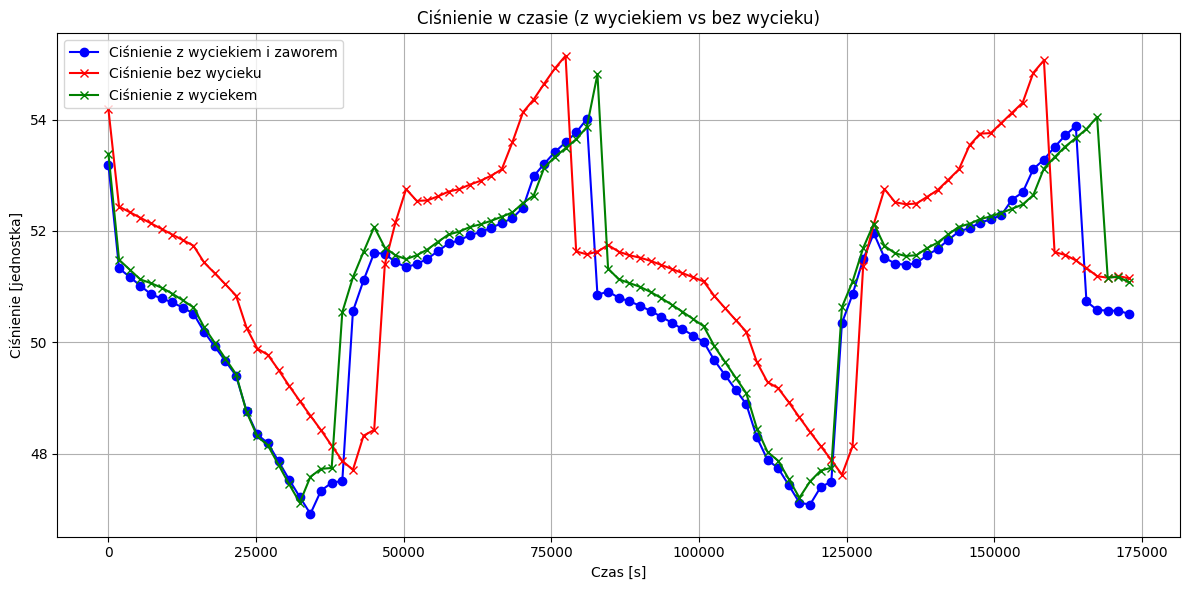

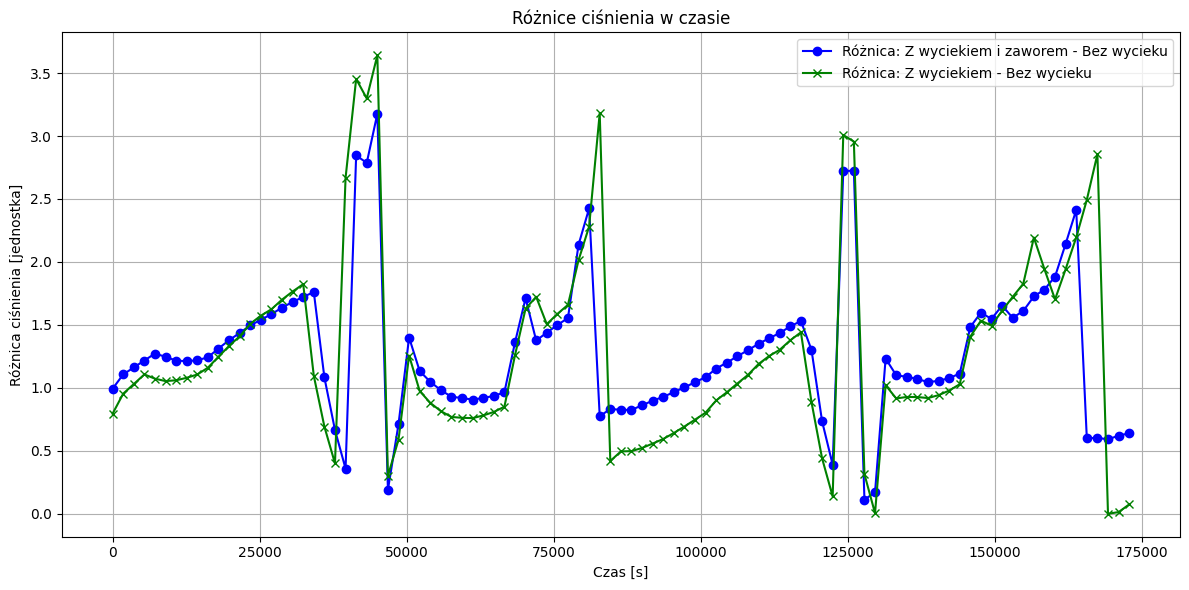

[124]

Placing valve 2...
wskaznik_best: 13.810652609510594

pipe: 63
wskaznik: 13.811082755254382

pipe: 14
wskaznik: 13.957733386556926

pipe: 24
wskaznik: 13.926545909972129

pipe: 179
wskaznik: 11026.478329464964

pipe: 199
wskaznik: 30.97988291031395

pipe: 301
wskaznik: 27.979168959923054

pipe: 302
wskaznik: 27.999856268104228

pipe: 128
wskaznik: 334947.8244921982

pipe: 83
wskaznik: 13.824571291810193

pipe: 346
wskaznik: 14.085631531685163

pipe: 37
wskaznik: 456.08948046137107

pipe: 243
wskaznik: 13.810991018568686

pipe: 244
wskaznik: 13.810337920778935
Pick_me_pipe: 244

pipe: 203
wskaznik: 14786.329350392762

pipe: 75
wskaznik: 13.834469898572475

pipe: 322
wskaznik: 13.864209306970018

pipe: 232
wskaznik: 724.452507492304

pipe: 68
wskaznik: 11428.691555900134

pipe: 73
wskaznik: 13.846791086431104

pipe: 78
wskaznik: 13.808111268641168
Pick_me_pipe: 78

pipe: 84
wskaznik: 13.798846252896297
Pick_me_pipe: 84

pipe: 90
wskaznik: 13.824801501702508

pipe: 96
wskaznik: 13.

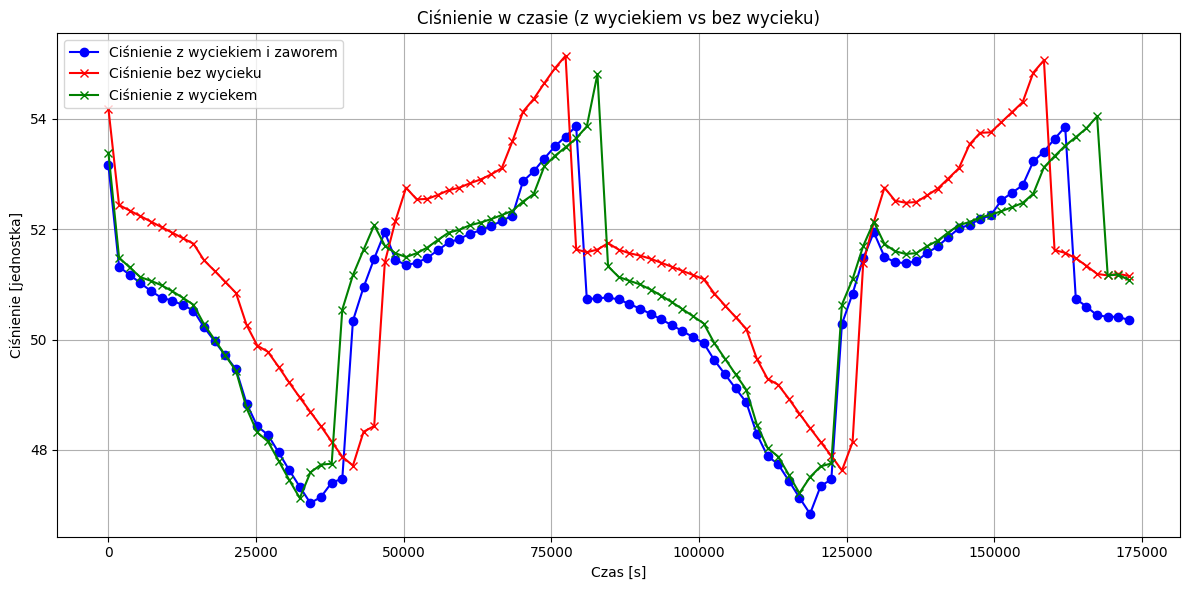

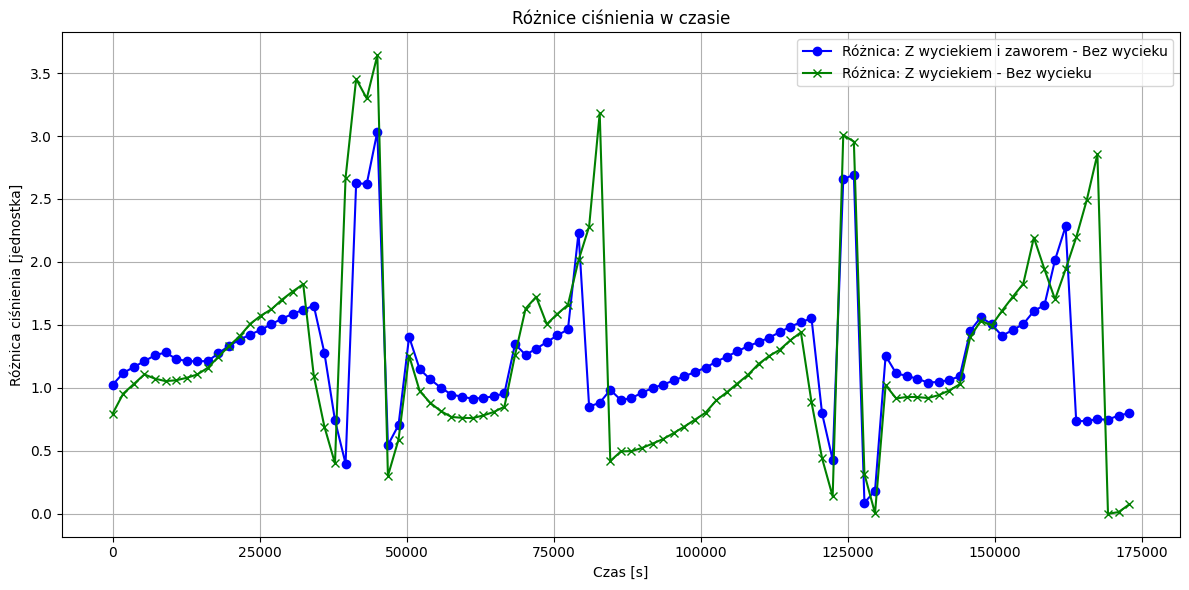

[124, 155]

Placing valve 3...
wskaznik_best: 13.292451727185979

pipe: 63
wskaznik: 13.292540416515093

pipe: 14
wskaznik: 33.914654616632866

pipe: 24
wskaznik: 13.082631678024367
Pick_me_pipe: 24

pipe: 179
wskaznik: 11026.902876784134

pipe: 199
wskaznik: 32.02086724484131

pipe: 301
wskaznik: 28.01345953409606

pipe: 302
wskaznik: 28.02826140435111

pipe: 128
wskaznik: 334948.24928097223

pipe: 83
wskaznik: 13.291616290024841

pipe: 346
wskaznik: 13.79121210710717

pipe: 37
wskaznik: 475.94238280961616

pipe: 243
wskaznik: 13.29255150236468

pipe: 244
wskaznik: 13.291823672030459

pipe: 203
wskaznik: 14786.754174742298

pipe: 75
wskaznik: 13.527057277086833

pipe: 322
wskaznik: 13.352897773200558

pipe: 232
wskaznik: 724.8641855866503

pipe: 68
wskaznik: 11429.116332425952

pipe: 73
wskaznik: 13.333662483485554

pipe: 78
wskaznik: 13.277108181405486

pipe: 84
wskaznik: 13.498789068090074

pipe: 90
wskaznik: 13.081536988008551
Pick_me_pipe: 90

pipe: 96
wskaznik: 13.292149237485372

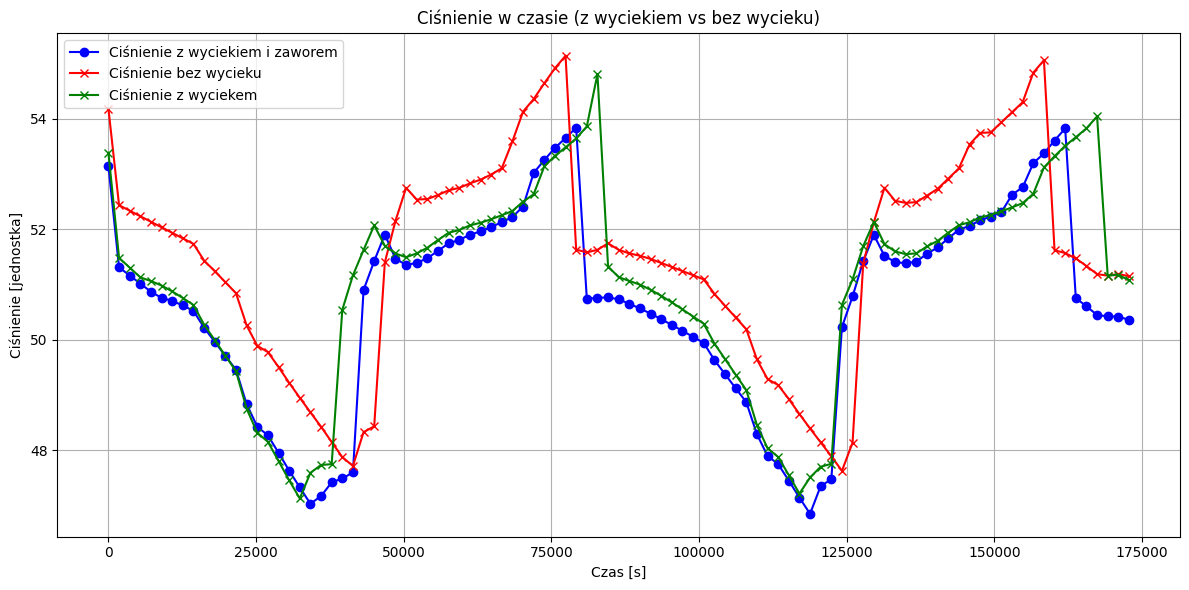

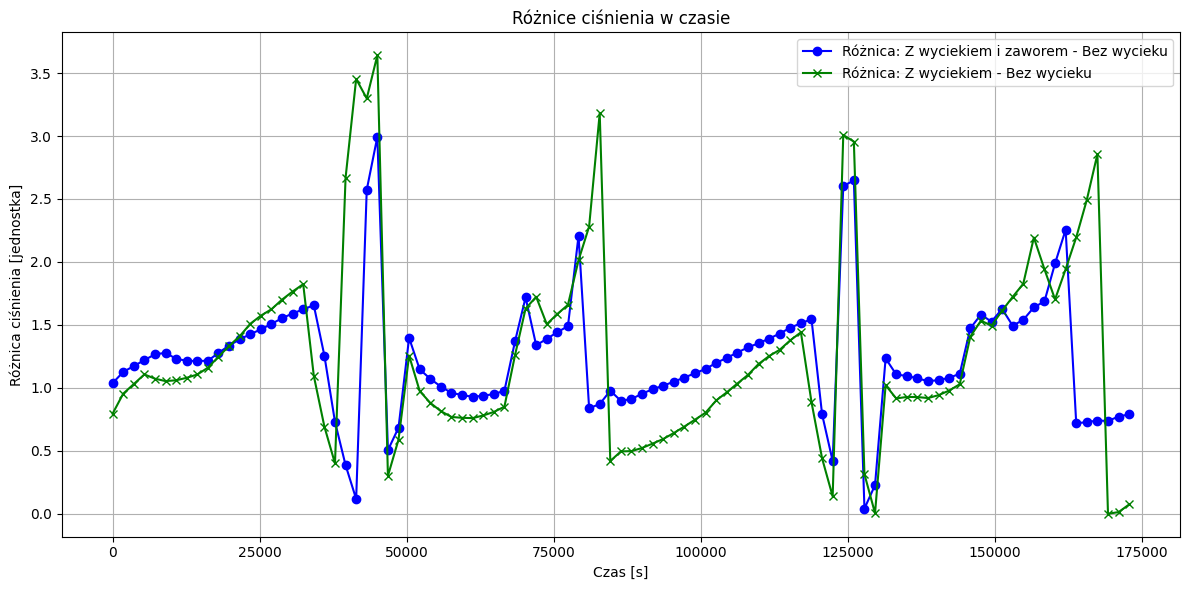

[124, 155, 90]

Placing valve 4...
wskaznik_best: 13.081536988008551

pipe: 63
wskaznik: 13.082013096138114

pipe: 14
wskaznik: 33.24051224582723

pipe: 24
wskaznik: 13.35507272866714

pipe: 179
wskaznik: 11027.225111937696

pipe: 199
wskaznik: 32.517630716634926

pipe: 301
wskaznik: 28.402492995204746

pipe: 302
wskaznik: 28.425449931845765

pipe: 128
wskaznik: 334948.5721990771

pipe: 83
wskaznik: 13.20620481266941

pipe: 346
wskaznik: 13.906271083232767

pipe: 37
wskaznik: 475.7167783871224

pipe: 243
wskaznik: 13.081970177757102

pipe: 244
wskaznik: 13.079654800303885
Pick_me_pipe: 244

pipe: 203
wskaznik: 14787.07654849798

pipe: 75
wskaznik: 13.244441574169626

pipe: 322
wskaznik: 13.424229176835505

pipe: 232
wskaznik: 725.1797377903388

pipe: 68
wskaznik: 11429.438614764846

pipe: 73
wskaznik: 13.39687336650502

pipe: 78
wskaznik: 13.187883940879296

pipe: 84
wskaznik: 13.261336096304015

pipe: 90

pipe: 96
wskaznik: 13.083014559037126

pipe: 98
wskaznik: 263314.29903883004

pi

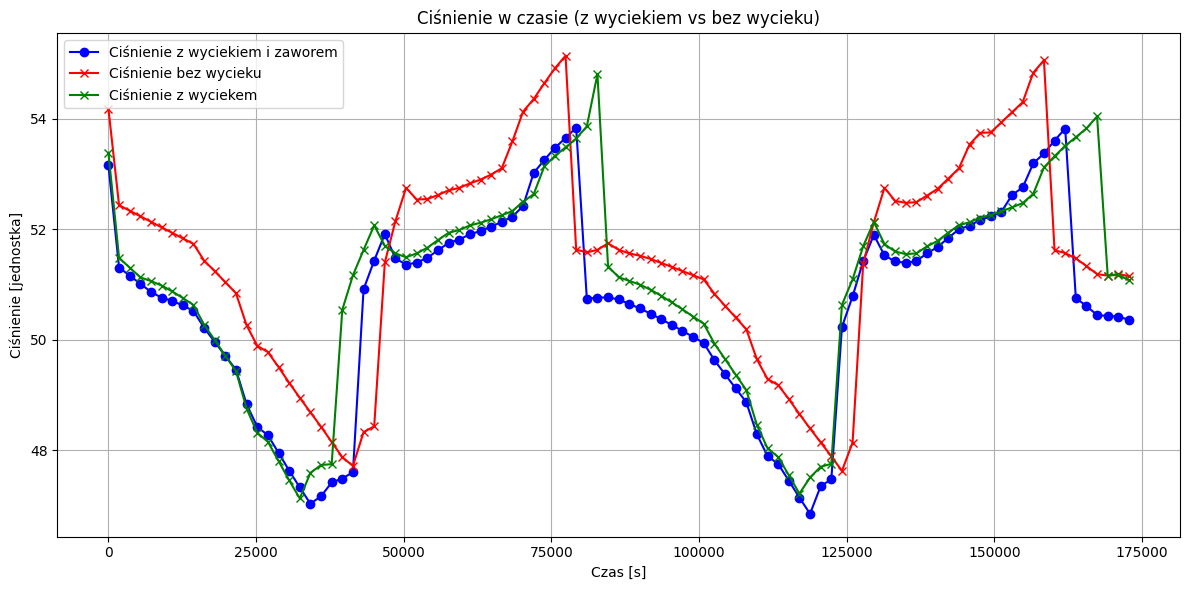

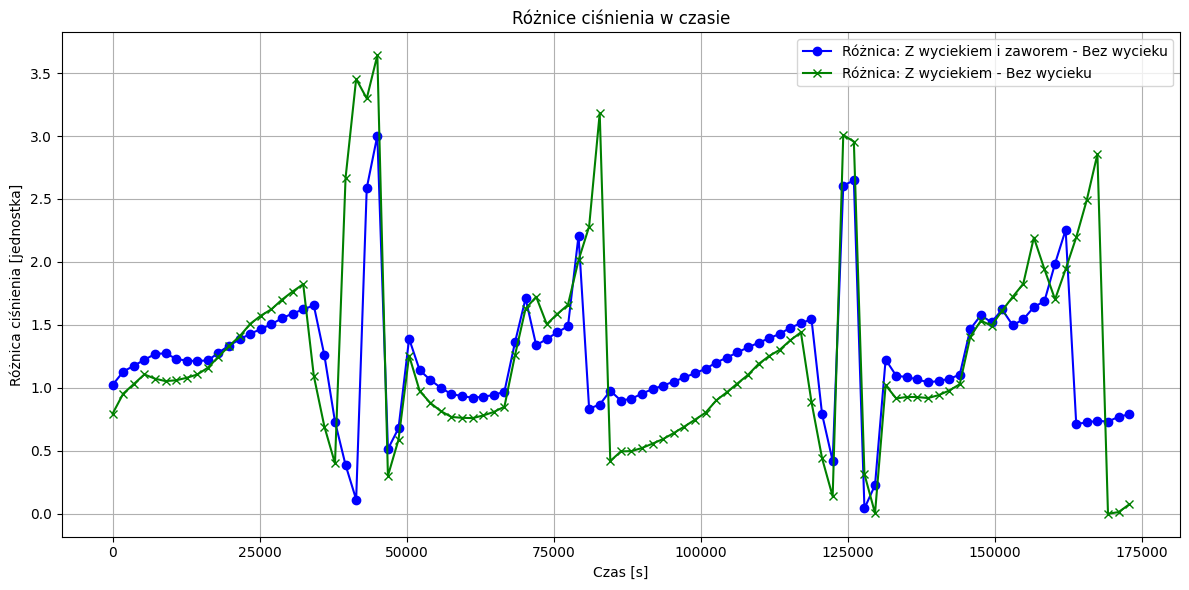

[124, 155, 90, 111]

Placing valve 5...
wskaznik_best: 13.072599520912052

pipe: 63
wskaznik: 13.072619251360587

pipe: 14
wskaznik: 32.35248792782454

pipe: 24
wskaznik: 12.864347759366341
Pick_me_pipe: 24

pipe: 179
wskaznik: 11027.21092770053

pipe: 199
wskaznik: 32.36398836157302

pipe: 301
wskaznik: 28.542665124112236

pipe: 302
wskaznik: 28.547797703479535

pipe: 128
wskaznik: 334948.558158906

pipe: 83
wskaznik: 12.991243289869331

pipe: 346
wskaznik: 13.902808993718633

pipe: 37
wskaznik: 475.6655739018601

pipe: 243
wskaznik: 13.072590464092226

pipe: 244
wskaznik: 13.292597518523303

pipe: 203
wskaznik: 14787.062297596665

pipe: 75
wskaznik: 13.257154465854741

pipe: 322
wskaznik: 13.404049401170777

pipe: 232
wskaznik: 725.1655244521233

pipe: 68
wskaznik: 11429.424400127737

pipe: 73
wskaznik: 13.377860241383882

pipe: 78
wskaznik: 13.180652622054339

pipe: 84
wskaznik: 13.253839255475024

pipe: 90

pipe: 96
wskaznik: 13.072220412957618

pipe: 98
wskaznik: 263314.2848872983

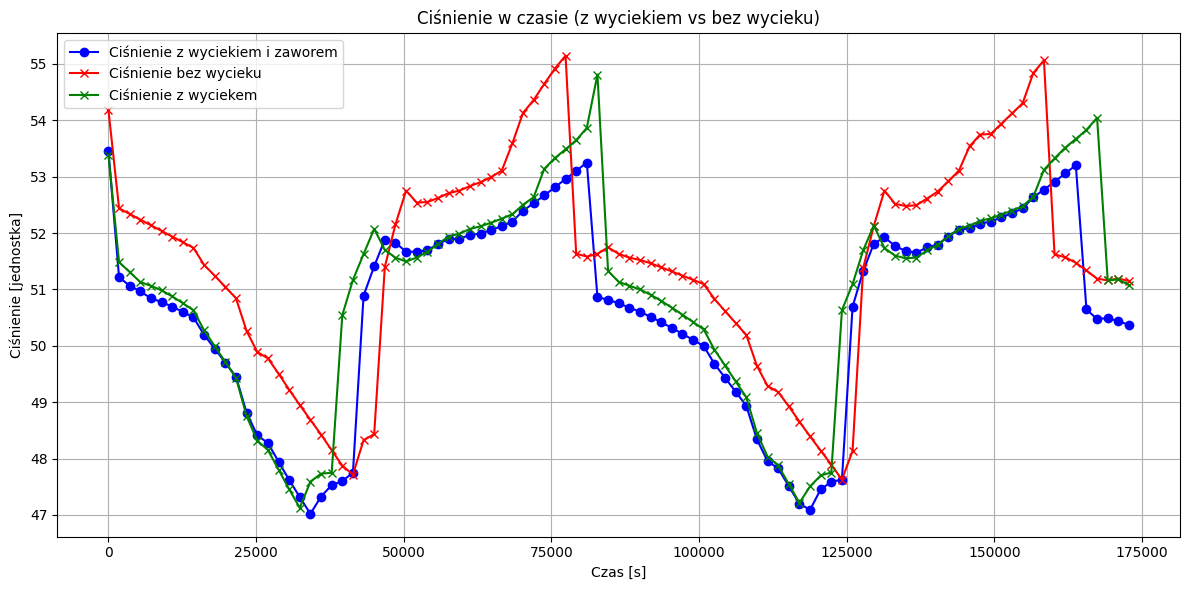

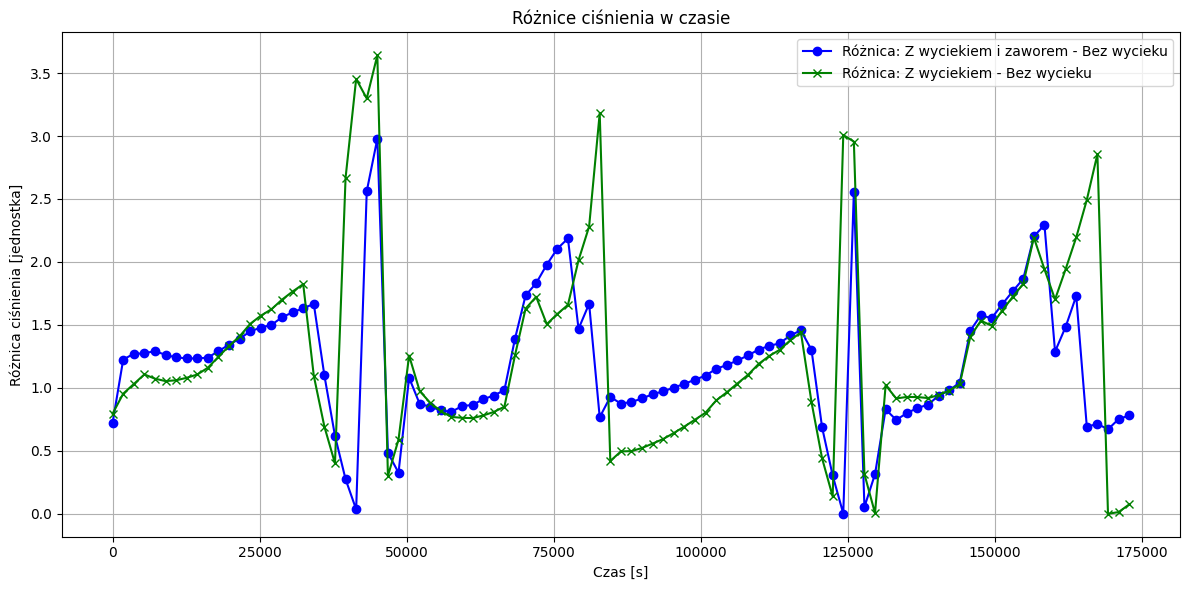

[124, 155, 90, 111, 24]

Placing valve 6...
wskaznik_best: 12.864347759366341

pipe: 63
wskaznik: 12.865534412728437

pipe: 14
wskaznik: 19.156011813407538

pipe: 24

pipe: 179
wskaznik: 11027.346175054996

pipe: 199
wskaznik: 109.62397363102427

pipe: 301
wskaznik: 40.16981519340268

pipe: 302
wskaznik: 40.4723873589926

pipe: 128
wskaznik: 334948.69256060274

pipe: 83
wskaznik: 12.950266404270467

pipe: 346
wskaznik: 14.185031086067816

pipe: 37
wskaznik: 469.85308458611075

pipe: 243
wskaznik: 12.864330170688056
Pick_me_pipe: 243

pipe: 244
wskaznik: 12.88283590636172

pipe: 203
wskaznik: 14787.19761916091

pipe: 75
wskaznik: 13.17438462526398

pipe: 322
wskaznik: 12.87861854538137

pipe: 232
wskaznik: 725.2960197106767

pipe: 68
wskaznik: 11429.559659590679

pipe: 73
wskaznik: 12.956548902388876

pipe: 78
wskaznik: 13.075293066965878

pipe: 84
wskaznik: 12.840095094089286
Pick_me_pipe: 84

pipe: 90

pipe: 96
wskaznik: 12.864152929491096

pipe: 98
wskaznik: 263314.42056812125

pipe:

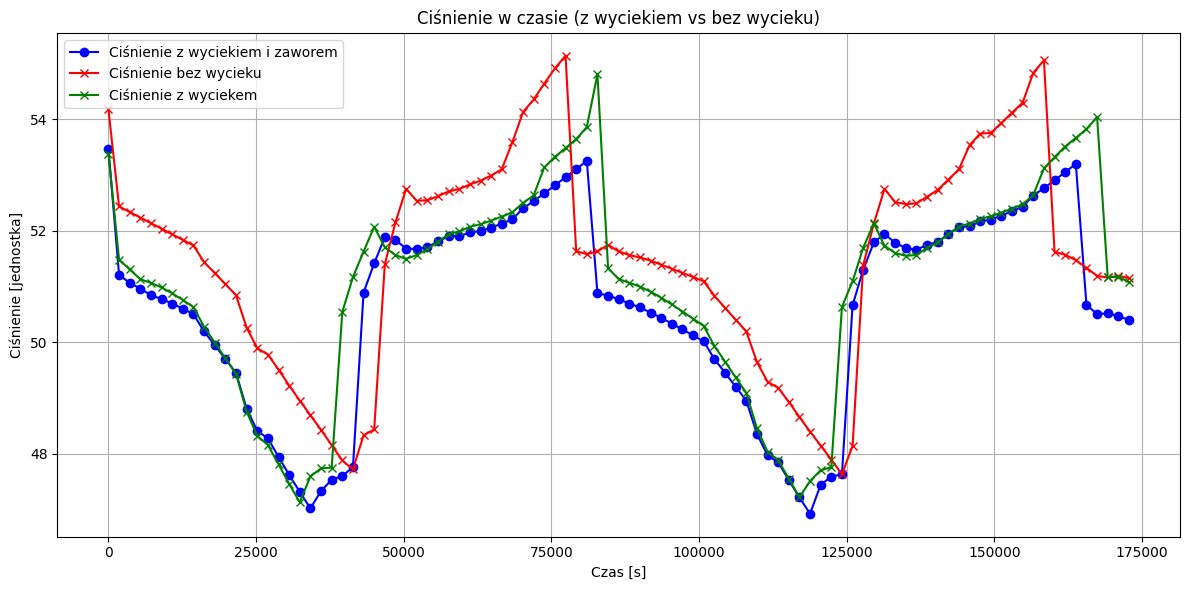

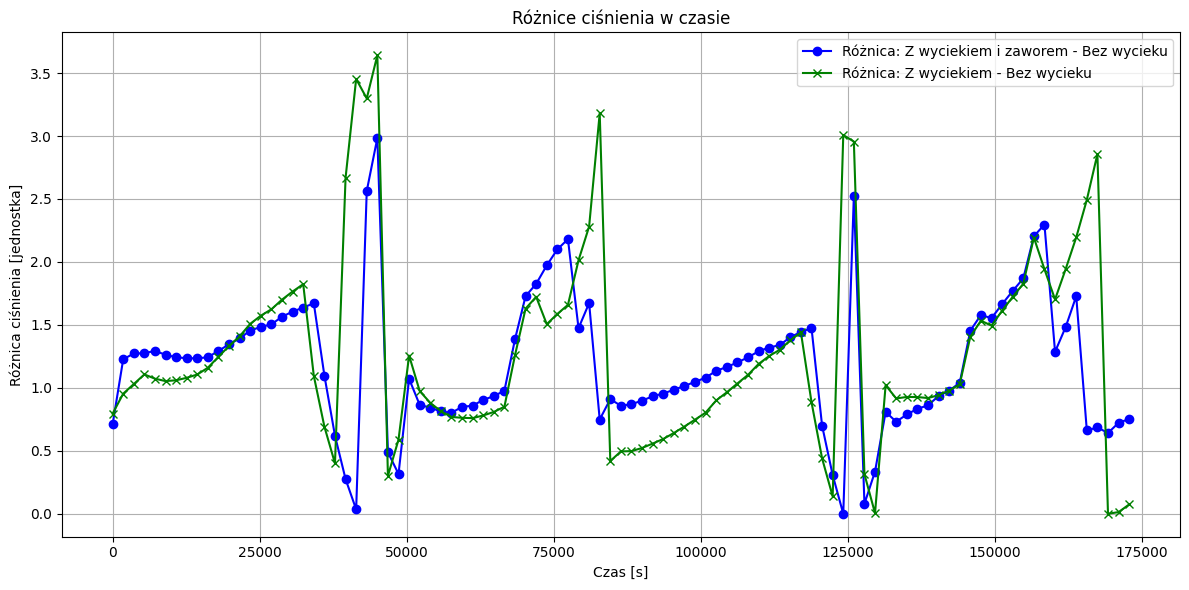

[124, 155, 90, 111, 24, 84]

Placing valve 7...
wskaznik_best: 12.840095094089286

pipe: 63
wskaznik: 12.840804815316732

pipe: 14
wskaznik: 19.708488817445033

pipe: 24

pipe: 179
wskaznik: 11027.3469907724

pipe: 199
wskaznik: 109.63801420041723

pipe: 301
wskaznik: 40.19706104322592

pipe: 302
wskaznik: 40.500132251393154

pipe: 128
wskaznik: 334948.69359603676

pipe: 83
wskaznik: 12.442011627261767
Pick_me_pipe: 83

pipe: 346
wskaznik: 13.960782373298889

pipe: 37
wskaznik: 469.8520497220492

pipe: 243
wskaznik: 12.840059834797541

pipe: 244
wskaznik: 12.837785343318657

pipe: 203
wskaznik: 14787.198358490627

pipe: 75
wskaznik: 13.16273579392799

pipe: 322
wskaznik: 12.86415470614729

pipe: 232
wskaznik: 725.2963681075547

pipe: 68
wskaznik: 11429.560403879022

pipe: 73
wskaznik: 12.923892963289621

pipe: 78
wskaznik: 13.045831168478244

pipe: 84

pipe: 90

pipe: 96
wskaznik: 12.839207305635215

pipe: 98
wskaznik: 263314.42162676685

pipe: 208
wskaznik: 1202305.8148890324

pipe: 3

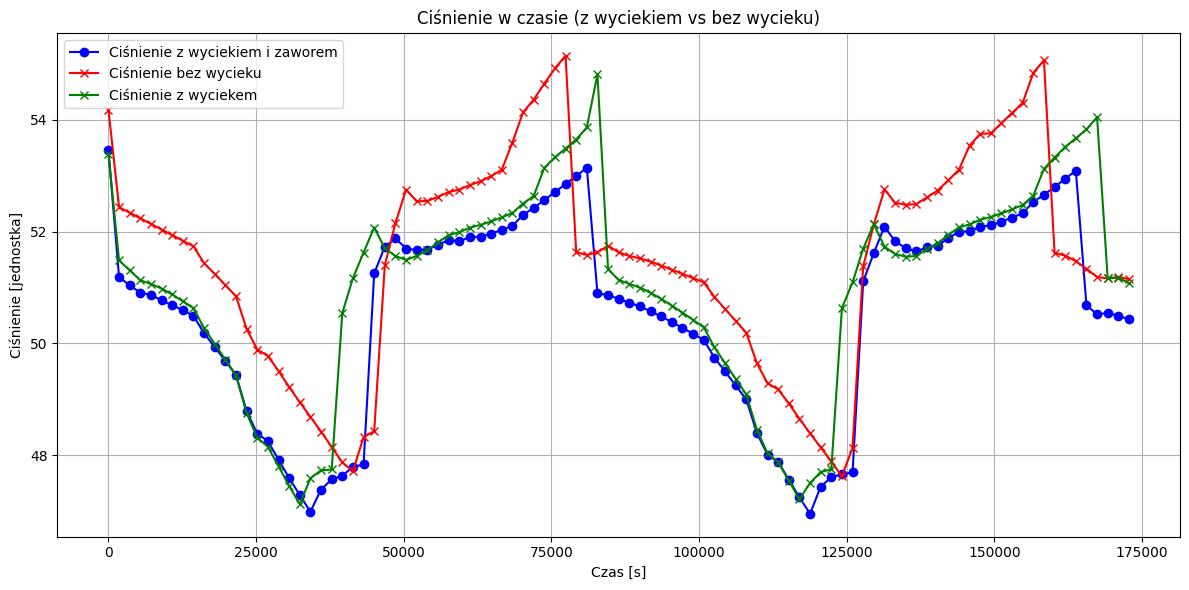

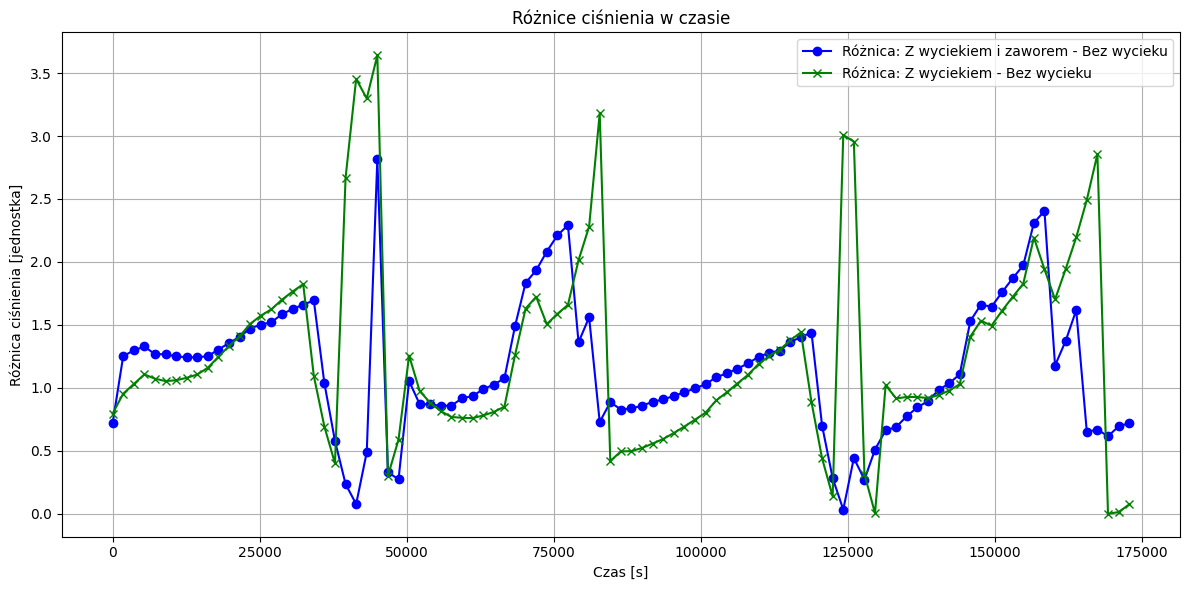

[124, 155, 90, 111, 24, 84, 83]

Placing valve 8...
wskaznik_best: 12.442011627261767

pipe: 63
wskaznik: 12.442974759349333

pipe: 14
wskaznik: 20.29710175086701

pipe: 24

pipe: 179
wskaznik: 11028.180559629654

pipe: 199
wskaznik: 112.55987809072215

pipe: 301
wskaznik: 38.626735661800495

pipe: 302
wskaznik: 38.93346215137304

pipe: 128
wskaznik: 334949.5279322963

pipe: 83

pipe: 346
wskaznik: 14.206560060209783

pipe: 37
wskaznik: 469.4737952161669

pipe: 243
wskaznik: 12.441997028242884
Pick_me_pipe: 243

pipe: 244
wskaznik: 12.44139219994914
Pick_me_pipe: 244

pipe: 203
wskaznik: 14788.032407918496

pipe: 75
wskaznik: 13.192065411793948

pipe: 322
wskaznik: 12.467219248744945

pipe: 232
wskaznik: 726.1148651137995

pipe: 68
wskaznik: 11430.394039426767

pipe: 73
wskaznik: 12.587257509954894

pipe: 78
wskaznik: 12.98568755670669

pipe: 84

pipe: 90

pipe: 96
wskaznik: 12.441460324789194

pipe: 98
wskaznik: 263315.2564407051

pipe: 208
wskaznik: 1202308.7603848942

pipe: 345
wska

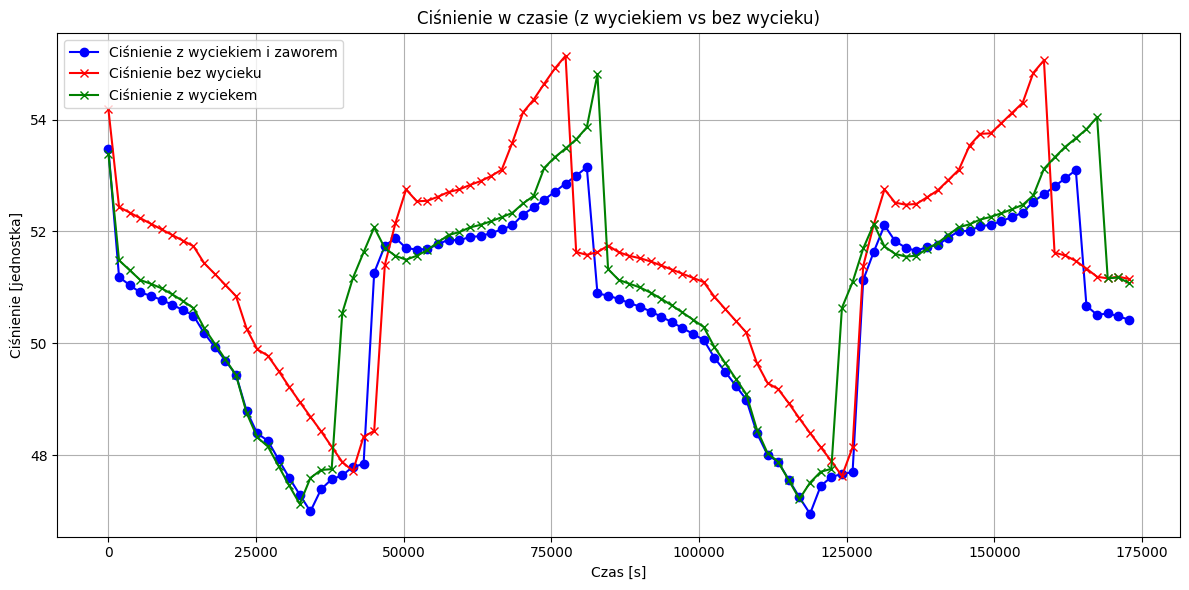

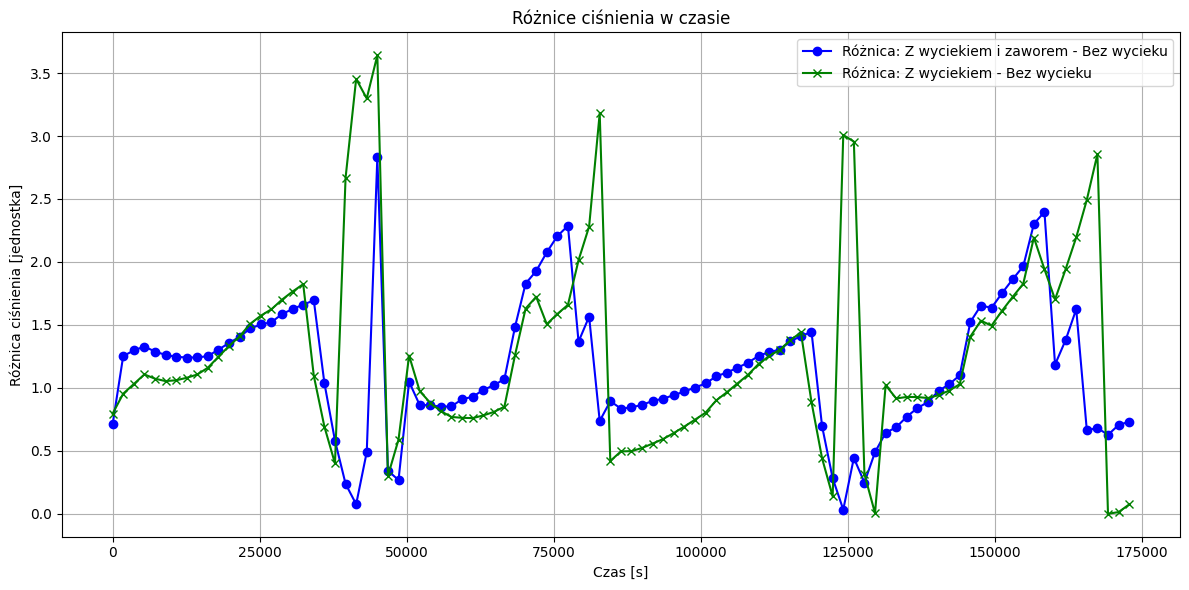

[124, 155, 90, 111, 24, 84, 83, 129]

Placing valve 9...
wskaznik_best: 12.439947016422432

pipe: 63
wskaznik: 12.440946765289954

pipe: 14
wskaznik: 20.278994820926922

pipe: 24

pipe: 179
wskaznik: 11028.167323462898

pipe: 199
wskaznik: 112.57293411312001

pipe: 301
wskaznik: 38.66933465827184

pipe: 302
wskaznik: 38.97556556868101

pipe: 128
wskaznik: 334949.5153314837

pipe: 83

pipe: 346
wskaznik: 14.216052353870491

pipe: 37
wskaznik: 469.4034315915109

pipe: 243
wskaznik: 12.439921639454338
Pick_me_pipe: 243

pipe: 244
wskaznik: 12.43953531544134
Pick_me_pipe: 244

pipe: 203
wskaznik: 14788.019148535815

pipe: 75
wskaznik: 13.19263963941286

pipe: 322
wskaznik: 12.464732327133103

pipe: 232
wskaznik: 726.1017847502915

pipe: 68
wskaznik: 11430.380826631736

pipe: 73
wskaznik: 12.583077002900515

pipe: 78
wskaznik: 12.990327800963035

pipe: 84

pipe: 90

pipe: 96
wskaznik: 12.43943288879944
Pick_me_pipe: 96

pipe: 98
wskaznik: 263315.24326080625

pipe: 208
wskaznik: 1202297.7472

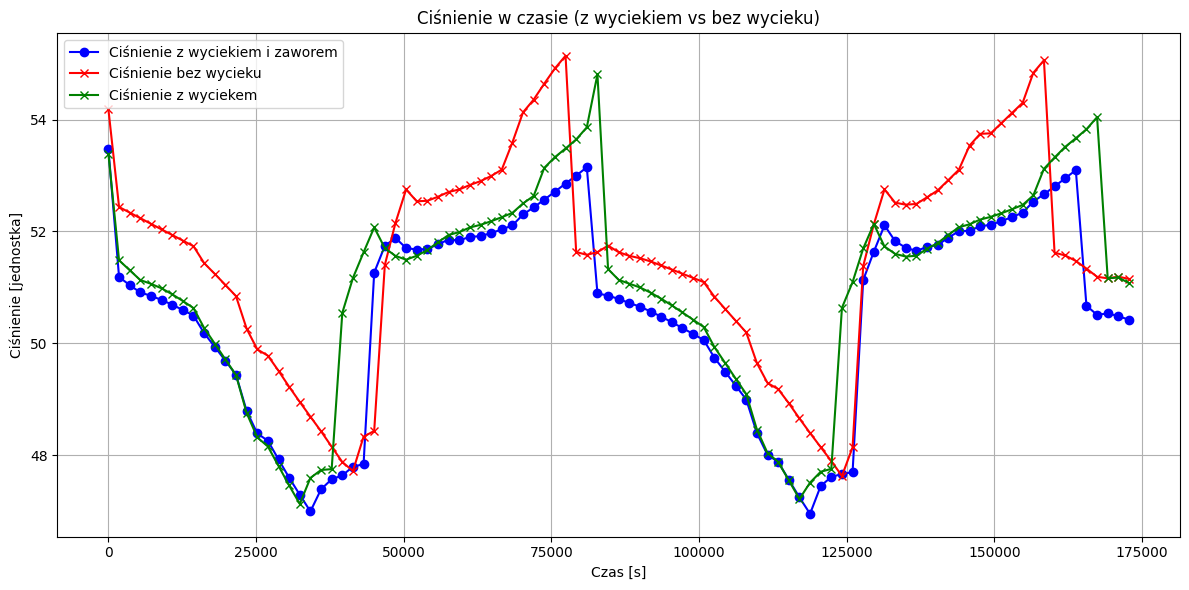

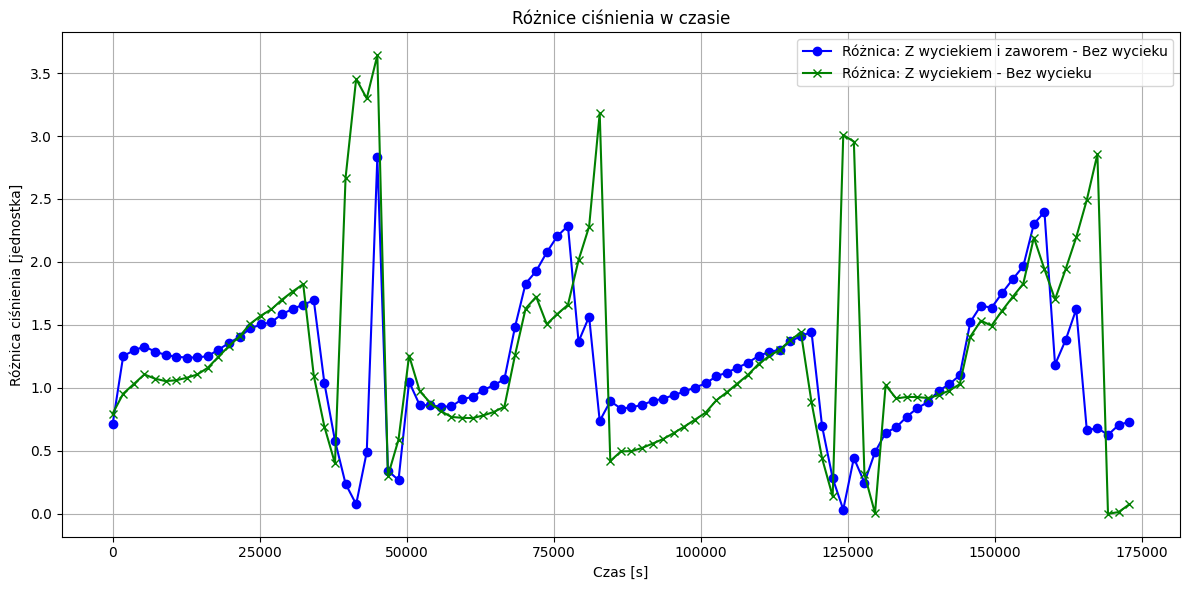

[124, 155, 90, 111, 24, 84, 83, 129, 96]

Placing valve 10...
wskaznik_best: 12.43943288879944

pipe: 63
wskaznik: 12.440186688918837

pipe: 14
wskaznik: 20.278675752653662

pipe: 24

pipe: 179
wskaznik: 11028.166711600612

pipe: 199
wskaznik: 112.57289524958102

pipe: 301
wskaznik: 53.47775434147375

pipe: 302
wskaznik: 54.01613444512771

pipe: 128
wskaznik: 334949.51469156943

pipe: 83

pipe: 346
wskaznik: 14.215277982993708

pipe: 37
wskaznik: 469.3943537222334

pipe: 243
wskaznik: 12.439398373607041
Pick_me_pipe: 243

pipe: 244
wskaznik: 12.438790522963401
Pick_me_pipe: 244

pipe: 203
wskaznik: 14788.018546614807

pipe: 75
wskaznik: 13.19161111260419

pipe: 322
wskaznik: 12.464159349251283

pipe: 232
wskaznik: 726.1011834447945

pipe: 68
wskaznik: 11430.380179293463

pipe: 73
wskaznik: 12.582319368165017

pipe: 78
wskaznik: 12.9896648173543

pipe: 84

pipe: 90

pipe: 96

pipe: 98
wskaznik: 263315.2426338026

pipe: 208
wskaznik: 1202300.349325554

pipe: 345
wskaznik: 14.421771373050

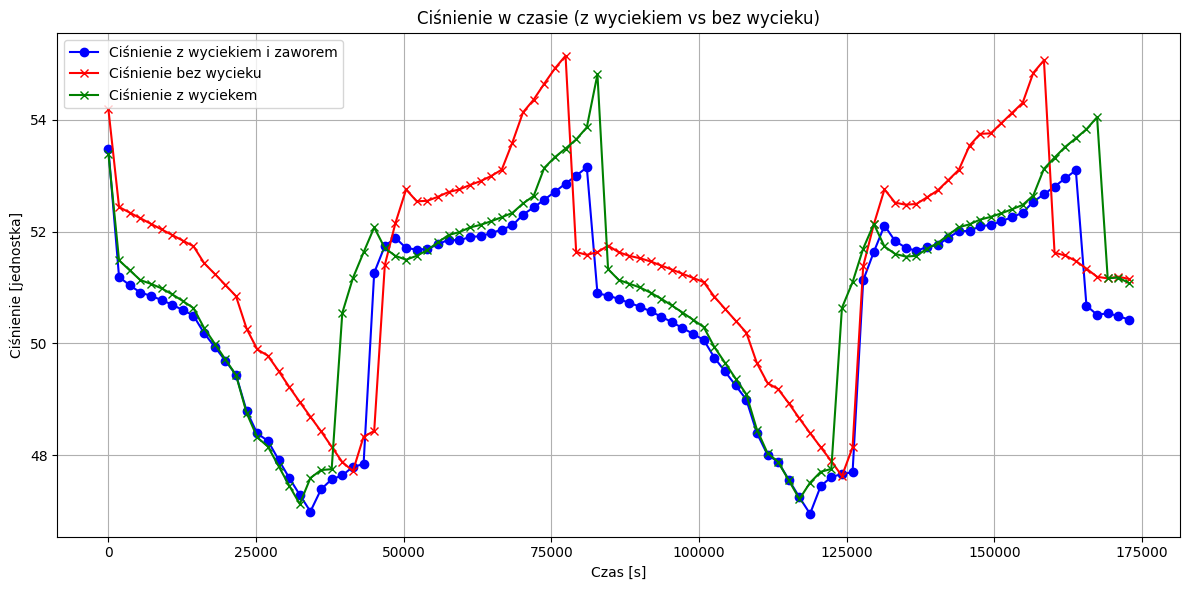

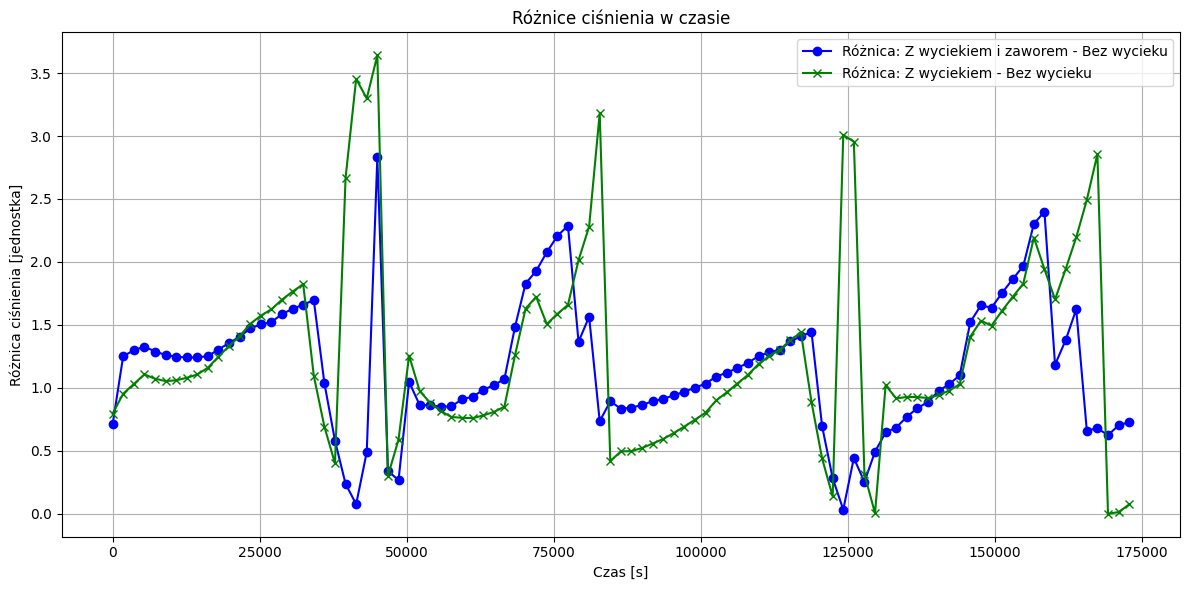

[124, 155, 90, 111, 24, 84, 83, 129, 96, 244]


In [13]:
leak_emit = 20
emit = d.getNodeEmitterCoeff()
emit = np.zeros_like(emit)

for leaknode in allleaknodes:
    leak_node_id = leaknode
    leak_node = d.getNodeIndex(leak_node_id)  # Get the node index
    emit[leak_node - 1] = leak_emit

d.setNodeEmitterCoeff(emit)

pressure_time_leak= DaneZSymulacji()
pressure_time_no_leak, pressure_time_leak = WspolnyCzas(pressure_time_no_leak, pressure_time_leak)
Wskaznik0 = OdlegloscEuklidesa(pressure_time_no_leak, pressure_time_leak)
print(f"wskaznik dla wycieku bez zaworów: {Wskaznik0}")
wskaznik_previous = Wskaznik0
BestPicks =[]


for valve_step in range(num_valves):
        print()
        print(f"Placing valve {valve_step + 1}...")

        Pick_me_pipe = 0
        wskaznik_best = wskaznik_previous
        print(f"wskaznik_best: {wskaznik_best}")


        for pipe in all_links:
                print()
                print(f"pipe: {pipe}")

                if pipe in restricted_pipes:
                      continue

                pipe_diameter = d.getLinkDiameter(pipe)
                d.setLinkDiameter(pipe, 1)
                pipe_diameterafter = d.getLinkDiameter(pipe)

                pressure_time_leak_pipe= DaneZSymulacji()
                pressure_time_no_leak, pressure_time_leak_pipe = WspolnyCzas(pressure_time_no_leak, pressure_time_leak_pipe)

                wskaznik = OdlegloscEuklidesa(pressure_time_no_leak, pressure_time_leak_pipe)
                print(f"wskaznik: {wskaznik}")

                if wskaznik <  wskaznik_best:
                        wskaznik_best = wskaznik
                        Pick_me_pipe = pipe
                        print(f"Pick_me_pipe: {Pick_me_pipe}")
                        pressure_time_leak_pipe_best = pressure_time_leak_pipe

                d.setLinkDiameter(pipe, pipe_diameter)
                pipe_diameterEND = d.getLinkDiameter(pipe)
        print(f"wskaznik_best:  {wskaznik_best}")
        if wskaznik_best >= wskaznik_previous:
                print("Wskaznik_best nie jest mniejszy niż wskaznik_previous, przerywam pętlę.")
                break

        wskaznik_previous = wskaznik_best
        print(f"Nowy wskaznik_previous: {wskaznik_previous}")

        restricted_pipes.append(Pick_me_pipe)
        BestPicks.append(Pick_me_pipe)
        d.setLinkDiameter(Pick_me_pipe, 1)
        print(f"Pick_me_pipe : {Pick_me_pipe}")
        print( d.getLinkDiameter(BestPicks))

        WykresZaworu(pressure_time_leak_pipe_best,pressure_time_no_leak,pressure_time_leak)
        pressure_time_leak_pipe_best, pressure_time_no_leak = WspolnyCzas(pressure_time_leak_pipe_best, pressure_time_no_leak)
        pressure_time_leak, pressure_time_no_leak = WspolnyCzas(pressure_time_leak, pressure_time_no_leak)
        WykresResiduum(pressure_time_leak_pipe_best,pressure_time_no_leak,pressure_time_leak)

        print(BestPicks)


[124, 155, 90, 111, 24, 84, 83, 129, 96, 244]


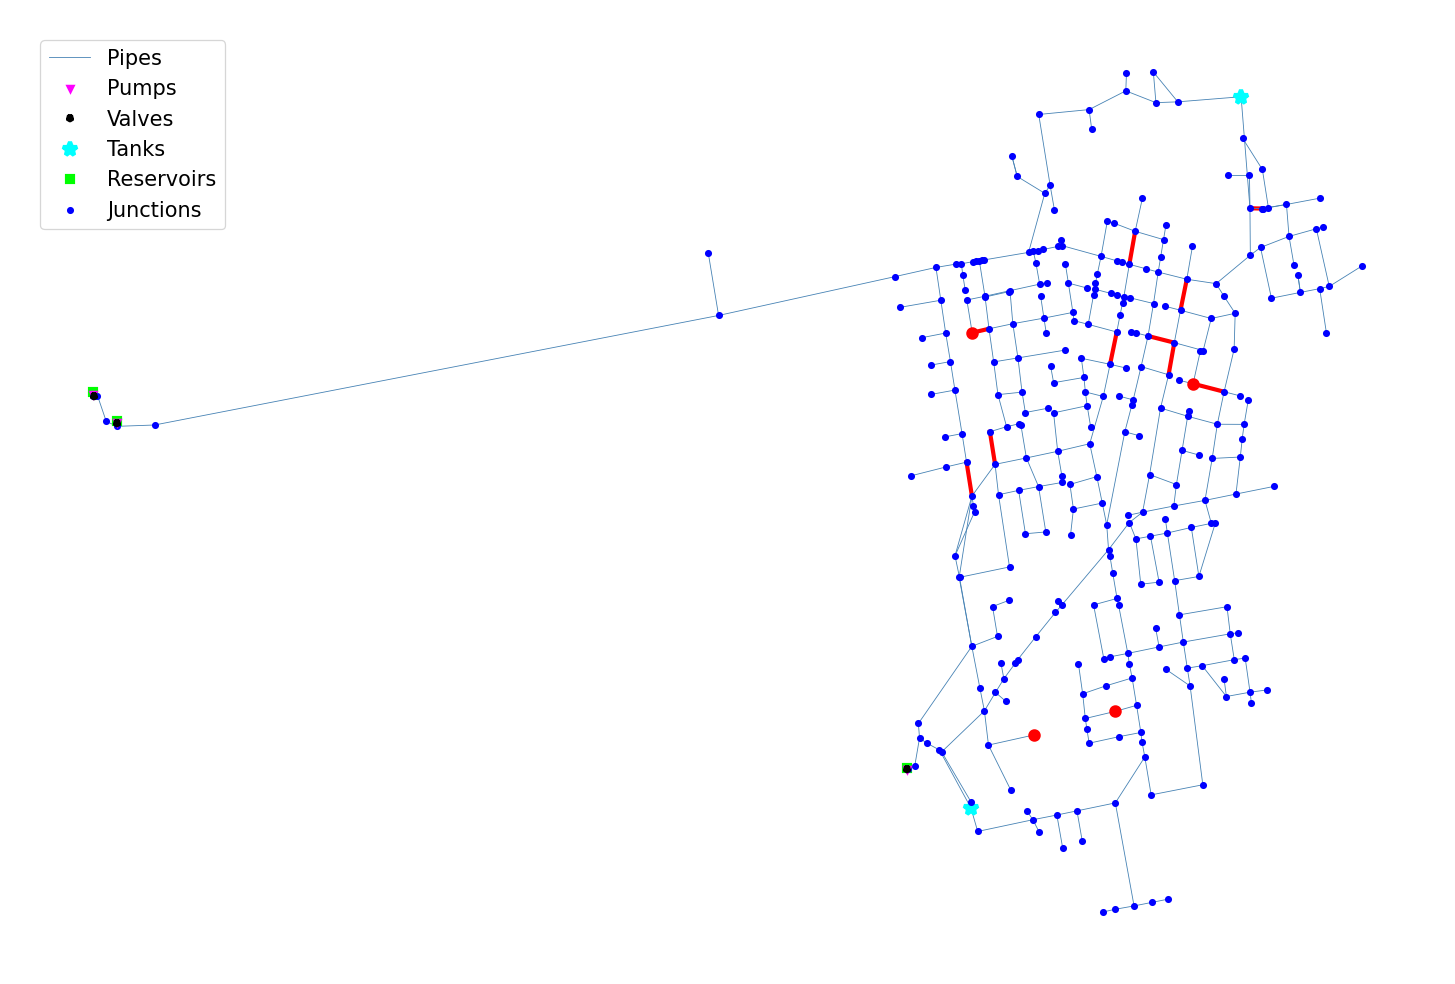

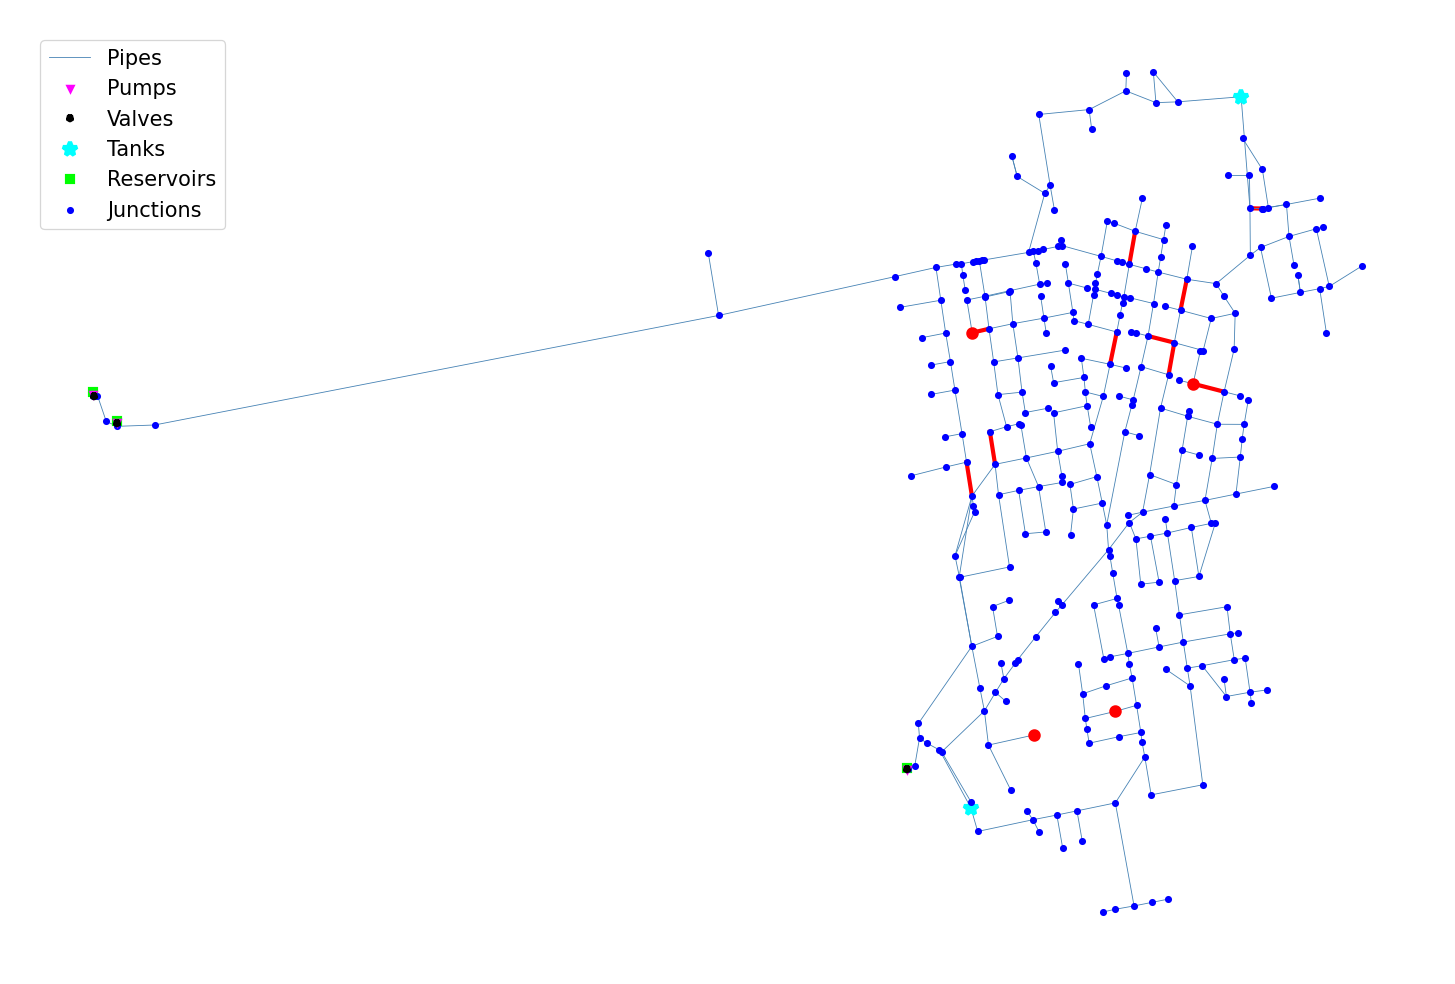

In [14]:

highlight_nodes = allleaknodes
highlight_links = BestPicks

print(BestPicks)
# Wykres sieci
d.plot(
    highlightnode=highlight_nodes,        # Węzły do wyróżnienia
    highlightlink=BestPicks,        # Rury do wyróżnienia
    fontsize=5,                           # Czcionka
    fig_size=[6, 4],                      # Rozmiar wykresu
    dpi=300,                              # Rozdzielczość
    highligthlink_linewidth=1,            # Grubość wyróżnionych rur
    highligthnode_linewidth=4,            # Grubość wyróżnionych węzłów
    colorbar_label="Values"               # Etykieta dla paska kolorów (opcjonalnie)
)
#[176, 124, 146, 155, 331, 142, 121, 216, 75, 217] zawory dla ['J211' , 'J155', 'J189', 'J56']
#[176, 124, 146, 155, 331, 142, 121, 216, 75, 217] dla ['J211' , 'J155', 'J189', 'J56']
#[210, 155, 124, 146, 278, 217, 143, 59, 171, 121] dla ['J155' , 'J236', 'J189', 'J85']
#[124, 155, 90, 111, 24, 84, 83, 129, 96, 244] dla [63, 14, 24, 179, 199, 301, 302, 128, 83, 346, 37, 243, 244, 203, 75, 322, 232, 68,
             #73, 78, 84, 90, 96, 98, 208, 345, 111, 112, 124, 116, 174, 120, 233, 126, 129, 155, 132, 133, 204, 266, 282]

In [ ]:
#Fuzzy_GNN_PINs

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from epyt import epanet
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

In [16]:
d = epanet('Walkerton_v1.inp')

d.setTimeSimulationDuration(2 * 24 * 60 * 60)
d.setTimePatternStart(0)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.



In [42]:
allleaknodes = ['J155', 'J236', 'J189', 'J85']
num_valves = 10
restricted_pipes = [359, 360, 361, 363, 349, 354]
all_links = d.getLinkIndex()
all_nodes = d.getNodeIndex()

def get_simulation_data(d):
    data = d.getComputedHydraulicTimeSeries(['Time', 'Pressure'])
    if hasattr(data, 'Pressure') and data.Pressure is not None:
        pressure_values = np.mean(data.Pressure, axis=1) if data.Pressure.ndim == 2 else np.array(data.Pressure)
        return np.column_stack((data.Time, pressure_values))
    else:
        print("Error: Pressure data not found")
        return None


In [18]:
# Initialization Fuzzy-GNN
class FuzzyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FuzzyGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
# Preparing the graph
def prepare_graph():
    G = nx.Graph()
    for link in all_links:
        nodes = d.getNodesConnectingLinksID(link)
        if isinstance(nodes, (list, np.ndarray)) and len(nodes) == 1:
            nodes = nodes[0]  # Unpacking
        if isinstance(nodes, (list, np.ndarray)) and len(nodes) == 2:
            start, end = nodes
            G.add_edge(start, end)
        else:
            print(f"Warning: Unexpected format for link {link}: {nodes}")
    return G

G = prepare_graph()

# Model initialization
input_dim = 2  # For example, node coordinates or other input parameters
hidden_dim = 16
output_dim = 1  # Output dimension (e.g. anomaly/leak)
model = FuzzyGNN(input_dim, hidden_dim, output_dim)

In [21]:
# Physically-based neural networks (PINNs)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [30]:
# Optimization using a metaheuristic algorithm
class ValveOptimizationProblem(Problem):
    def __init__(self, n_var, n_obj=1):
        # Filter only valid pipes
        self.allowed_links = [
            lid for lid in all_links
            if lid not in restricted_pipes and d.getLinkType(lid) != 'PUMP'
        ]
        super().__init__(n_var=n_var, n_obj=n_obj, xl=0, xu=len(self.allowed_links)-1, type_var=int)

        # We keep the original diameters
        self.original_diameters = {lid: d.getLinkDiameter(lid) for lid in self.allowed_links}

In [31]:
 def _evaluate(self, X, out, *args, **kwargs):
        fitness = []

        for solution in X:
            # We restore the diameters to the original
            for lid, dia in self.original_diameters.items():
                d.setLinkDiameter(lid, dia)

            valid = True
            selected_links = []
            for valve_idx in solution:
                try:
                    valve_idx = int(round(valve_idx))
                    link_id = self.allowed_links[valve_idx]
                    # New diameter change: not less than 20% of the original
                    new_d = max(0.2, self.original_diameters[link_id] * 0.9)
                    d.setLinkDiameter(link_id, new_d)
                    selected_links.append(link_id)
                except (IndexError, KeyError):
                    valid = False
                    break

            if not valid:
                fitness.append(float('inf'))
                continue

            # We get data after simulation
            data = get_simulation_data()
            if data is None or np.isnan(data).any():
                fitness.append(float('inf'))
                continue

            # minimize the L2-norm of pressures
            score = np.linalg.norm(data[:, 1])
            fitness.append(score)

        out["F"] = np.array(fitness)



In [32]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [33]:
import numpy as np

num_valves = 10  # Number of valves (replace with your value)
X = np.random.randint(0, 364, size=(50, num_valves))  # 50 solutions, each with num_valves elements
print(f"X (first 5 solutions):\n{X[:5]}")

X (first 5 solutions):
[[167  66 245 120 337 219 135 361 111 146]
 [209 185  87 341  13  73  49 242 105 285]
 [119 137  26 215 110 125 325  18 336 204]
 [ 95 333 112  95 234 160  79 116 355 354]
 [ 62 201 251 314 344 206 266  93 112 291]]


In [34]:
for solution in X:
    for valve in solution:
        print(f"Processing valve: {valve}")

Processing valve: 167
Processing valve: 66
Processing valve: 245
Processing valve: 120
Processing valve: 337
Processing valve: 219
Processing valve: 135
Processing valve: 361
Processing valve: 111
Processing valve: 146
Processing valve: 209
Processing valve: 185
Processing valve: 87
Processing valve: 341
Processing valve: 13
Processing valve: 73
Processing valve: 49
Processing valve: 242
Processing valve: 105
Processing valve: 285
Processing valve: 119
Processing valve: 137
Processing valve: 26
Processing valve: 215
Processing valve: 110
Processing valve: 125
Processing valve: 325
Processing valve: 18
Processing valve: 336
Processing valve: 204
Processing valve: 95
Processing valve: 333
Processing valve: 112
Processing valve: 95
Processing valve: 234
Processing valve: 160
Processing valve: 79
Processing valve: 116
Processing valve: 355
Processing valve: 354
Processing valve: 62
Processing valve: 201
Processing valve: 251
Processing valve: 314
Processing valve: 344
Processing valve: 206

In [35]:
if 0 <= valve < len(all_links):
    d.setLinkDiameter(all_links[valve], 1)
else:
    print(f"Error: valve={valve} goes beyond the list all_links")

In [36]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation

# Make sure num_valves is defined
if 'num_valves' not in globals():
    num_valves = 10  # Default value, change as needed

# We make sure that ValveOptimizationProblem determined
if 'ValveOptimizationProblem' not in globals():
    class ValveOptimizationProblem:
        def __init__(self, n_var):
            self.n_var = n_var
        # Add the necessary methods for optimization

# Initializing the GA algorithm
algorithm = GA(
    pop_size=50,
    sampling=IntegerRandomSampling(),
    crossover=SimulatedBinaryCrossover(),
    mutation=PolynomialMutation(),
    eliminate_duplicates=True
)

# Initialization of the problem
problem = ValveOptimizationProblem(n_var=num_valves)

# Performing optimization
try:
    result = minimize(problem, algorithm, ('n_gen', 20), verbose=True)
    print("Optimization completed successfully!")
except Exception as e:
    print(f"Error during optimization: {e}")

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |           INF |           INF
     2 |      100 |           INF |           INF
     3 |      150 |           INF |           INF
     4 |      200 |           INF |           INF
     5 |      250 |           INF |           INF
     6 |      300 |           INF |           INF
     7 |      350 |           INF |           INF
     8 |      400 |           INF |           INF
     9 |      450 |           INF |           INF
    10 |      500 |           INF |           INF
    11 |      550 |           INF |           INF
    12 |      600 |           INF |           INF
    13 |      650 |           INF |           INF
    14 |      700 |           INF |           INF
    15 |      750 |           INF |           INF
    16 |      800 |           INF |           INF
    17 |      850 |           INF |           INF
    18 |      900 |           INF |           INF
    19 |      950 |           INF |           INF


In [ ]:
#Replacing EPANET → PINN

In [43]:
from epyt import epanet
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

def get_simulation_data(d):
    data = d.getComputedHydraulicTimeSeries(['Time', 'Pressure'])
    if hasattr(data, 'Pressure') and data.Pressure is not None:
        pressure_values = np.mean(data.Pressure, axis=1) if data.Pressure.ndim == 2 else np.array(data.Pressure)
        return np.column_stack((data.Time, pressure_values))
    return None

X_data = []
y_data = []

for _ in range(200):
    d = epanet('Walkerton_v1.inp')
    d.setTimeSimulationDuration(2 * 24 * 60 * 60)
    d.setTimePatternStart(0)
    all_links = d.getLinkIndex()

    selected = np.random.choice(all_links, size=10, replace=False)
    for lid in selected:
        orig_d = d.getLinkDiameter(lid)
        d.setLinkDiameter(lid, max(0.2, orig_d * 0.9))

    data = get_simulation_data(d)
    if data is not None and not np.isnan(data).any():
        X_data.append(selected)
        y_data.append(np.mean(data[:, 1]))

# Scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X_data)
y_scaled = y_scaler.fit_transform(np.array(y_data).reshape(-1, 1))

# PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.



/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.



/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.



/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.



/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())
/usr/local/lib/python3.11/dist-packages/epyt/epanet.py:14410: UserWarning: WARNING: Valves cannot deliver enough flow.
  warnings.warn(errmssg.value.decode())


EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded successfully.

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Walkerton_v1.inp loaded

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen

Epoch 0: Loss = 0.5115
Epoch 50: Loss = 0.0875
Epoch 100: Loss = 0.0797
Epoch 150: Loss = 0.0783
Epoch 200: Loss = 0.0772
Epoch 250: Loss = 0.0758
